<a href="https://colab.research.google.com/github/SuperYoungCoder/Machine-Learning-with-Python-Tensorflow/blob/main/linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Linear regression

This project aims to build models to predict the fuel efficiency of the late-1970s and early 1980s automobiles. The classic [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) data set was sourced from the archives of UCI.

In [2]:
# This project uses the Kreas Api
## Install and import seaborn for pairport
!pip install -q seaborn
import seaborn as sns

## Import matplotlib, pandas, and tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd

## Import NumPy and make NumPy printouts easier to read
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=2, suppress=True)
print(tf.__version__)

2.8.2


##1. Import the data

In [19]:
# The Auto MPG dataset
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


##2. Clean the data

In [20]:
# The dataset contains 'na' values
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [21]:
# Drop 'na' values
dataset = dataset.dropna()

In [23]:
# The 'Origin' column is categorical. So assing one-hot encode with pd.get_dummies
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [24]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year
393,27.0,4,140.0,86.0,2790.0,15.6,82
394,44.0,4,97.0,52.0,2130.0,24.6,82
395,32.0,4,135.0,84.0,2295.0,11.6,82
396,28.0,4,120.0,79.0,2625.0,18.6,82
397,31.0,4,119.0,82.0,2720.0,19.4,82


##3. Separate the data: training and test sets

In [25]:
train_dataset = dataset.sample(frac=0.4, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
print(train_dataset)
print(test_dataset)

      MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
146  28.0          4          90.0        75.0  2125.0          14.5   
282  22.3          4         140.0        88.0  2890.0          17.3   
69   12.0          8         350.0       160.0  4456.0          13.5   
378  38.0          4         105.0        63.0  2125.0          14.7   
331  33.8          4          97.0        67.0  2145.0          18.0   
..    ...        ...           ...         ...     ...           ...   
135  18.0          6         225.0       105.0  3613.0          16.5   
34   16.0          6         225.0       105.0  3439.0          15.5   
376  37.0          4          91.0        68.0  2025.0          18.2   
35   17.0          6         250.0       100.0  3329.0          15.5   
201  18.5          6         250.0       110.0  3645.0          16.2   

     Model Year  
146          74  
282          79  
69           72  
378          82  
331          80  
..          ...  
135      

##4. Data in Graphs

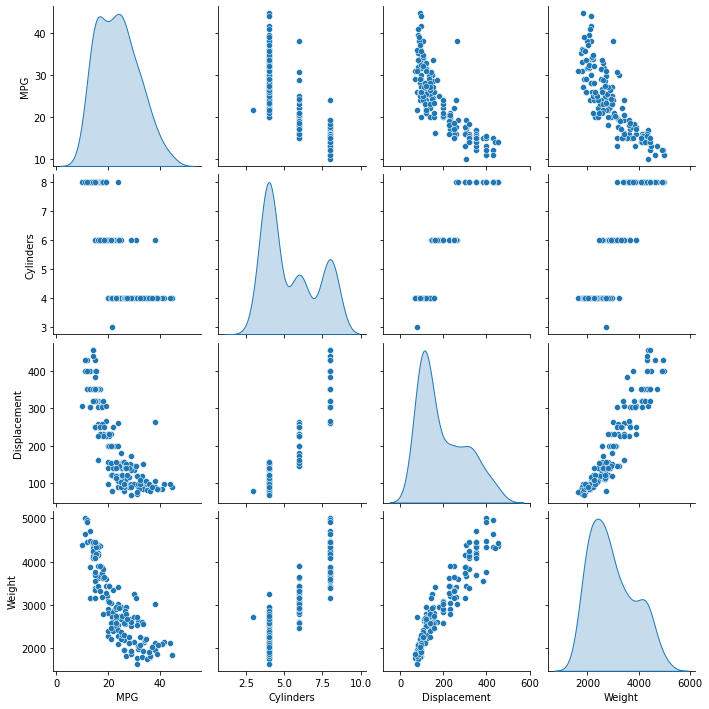

In [26]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [27]:
# Summary Statistics
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,157.0,23.669427,7.829707,10.0,16.9,23.0,29.0,44.6
Cylinders,157.0,5.445860,1.711181,3.0,4.0,4.0,8.0,8.0
Displacement,157.0,194.509554,107.094651,68.0,105.0,146.0,267.0,455.0
Horsepower,157.0,104.019108,39.013060,46.0,75.0,90.0,129.0,225.0
Weight,157.0,2966.496815,857.845121,1649.0,2226.0,2745.0,3613.0,4997.0
Acceleration,157.0,15.555414,2.688041,8.5,14.0,15.5,17.3,24.6
Model Year,157.0,75.898089,3.676301,70.0,73.0,76.0,79.0,82.0


##5. Split features from labels

In [28]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()
train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

#II. Normalization
1. The Normalization layer

In [29]:
# The Normalization layer
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.669427,7.829707
Cylinders,5.445860,1.711181
Displacement,194.509554,107.094651
Horsepower,104.019108,39.013060
Weight,2966.496815,857.845121
Acceleration,15.555414,2.688041
Model Year,75.898089,3.676301


In [30]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[   5.45  194.51  104.02 2966.5    15.56   75.9 ]]


In [31]:
sample = np.array(train_features[:1])
with np.printoptions(precision=4, suppress=True):
  print('First sample:', sample)
  print('Normalized:', normalizer(sample).numpy())

First sample: [[   4.    90.    75.  2125.    14.5   74. ]]
Normalized: [[-0.8477 -0.979  -0.7462 -0.9841 -0.3939 -0.518 ]]


##1. Linear regression with one variable

In [32]:
weight = np.array(train_features['Weight'])

weight_normalizer = layers.Normalization(input_shape=[1,], axis=None)
weight_normalizer.adapt(weight)

# The Keras Sequential model
weight_model = tf.keras.Sequential([
    weight_normalizer,
    layers.Dense(units=1)
])

weight_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [33]:
# Note: this model will predict 'MPG' from 'Weight'.
weight_model.predict(weight[:20])

array([[ 0.46],
       [ 0.04],
       [-0.82],
       [ 0.46],
       [ 0.45],
       [-0.13],
       [ 0.55],
       [-0.16],
       [-0.07],
       [ 0.38],
       [ 0.63],
       [-0.78],
       [ 0.13],
       [-1.12],
       [-0.77],
       [ 0.42],
       [ 0.09],
       [-0.61],
       [ 0.39],
       [ 0.16]], dtype=float32)

In [34]:
weight_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.4),
    loss='mean_absolute_error')


In [35]:
# Training
%%time
history = weight_model.fit(
    train_features['Weight'],
    train_labels,
    epochs=200,
    verbose=0,
    validation_split = 0.15)

CPU times: user 5.16 s, sys: 206 ms, total: 5.37 s
Wall time: 5.06 s


In [36]:
# Visualizing the model
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
195,3.389608,2.691764,195
196,3.381959,2.704003,196
197,3.380885,2.707513,197
198,3.382496,2.717186,198
199,3.381081,2.718833,199


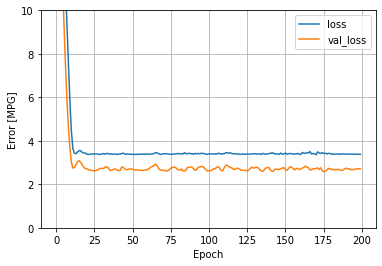

In [37]:
#Plotting the loss on a graph
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
plot_loss(history)

In [38]:
test_results = {}

test_results['weight_model'] = weight_model.evaluate(
    test_features['Weight'],
    test_labels, verbose=0)

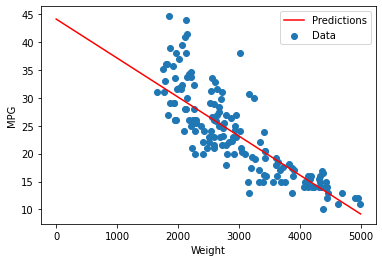

In [49]:
x = tf.linspace(0.0, 5000, 5001)
y = weight_model.predict(x)

def plot_weight(x, y):
  plt.scatter(train_features['Weight'], train_labels, label='Data')
  plt.plot(x, y, color='r', label='Predictions')
  plt.xlabel('Weight')
  plt.ylabel('MPG')
  plt.legend()
plot_weight(x, y)

##2. Linear regression with multiple inputs

In [40]:
# Linear regression with multiple inputs
linear_model = tf.keras.Sequential([
                                    normalizer,
                                    layers.Dense(units=1)
])
linear_model.summary()
linear_model.predict(train_features[:20])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 6)                13        
 n)                                                              
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 20
Trainable params: 7
Non-trainable params: 13
_________________________________________________________________


array([[ 0.63],
       [ 1.49],
       [-2.53],
       [ 1.62],
       [ 1.91],
       [ 0.45],
       [ 2.12],
       [ 2.69],
       [-0.13],
       [ 1.11],
       [ 1.25],
       [-2.67],
       [ 1.05],
       [-2.14],
       [-1.55],
       [ 1.31],
       [ 0.73],
       [-2.34],
       [ 0.5 ],
       [ 1.21]], dtype=float32)

In [41]:
linear_model.layers[1].kernel
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.4),
    loss='mean_absolute_error')

CPU times: user 5.16 s, sys: 238 ms, total: 5.4 s
Wall time: 5.09 s


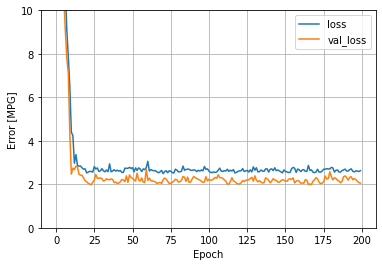

In [42]:
# Training
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=200,
    verbose=0,
    validation_split= 0.15
)
plot_loss(history)

In [43]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)


In [44]:
# Regression with a deep neural network
def build_and_compile_model(norm):
  model = keras.Sequential([
                            norm,
                            layers.Dense(64, activation='relu'),
                            layers.Dense(64, activation='relu'),
                            layers.Dense(1)
  ])
  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

##1. Regression using a DNN and a signle input

In [45]:
# Regression using a DNN and a single input: 'Acceleration'
dnn_weight_model = build_and_compile_model(weight_normalizer)
dnn_weight_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


CPU times: user 5.49 s, sys: 254 ms, total: 5.75 s
Wall time: 5.26 s


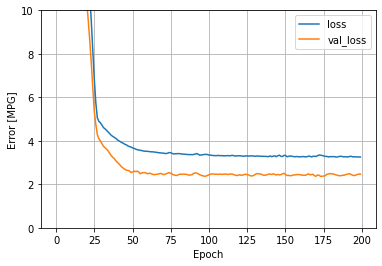

In [46]:
# Training
%%time
history = dnn_weight_model.fit(
    train_features['Weight'],
    train_labels,
    validation_split=0.15,
    verbose=0, epochs=200)
plot_loss(history)

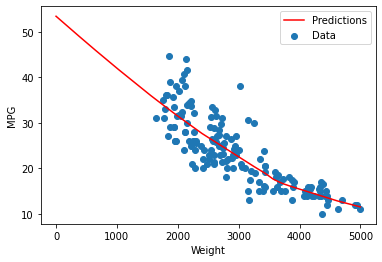

In [48]:
x = tf.linspace(0.0, 5000, 5001)
y = dnn_weight_model.predict(x)
plot_weight(x, y)

In [50]:
test_results['dnn_weight_model'] = dnn_weight_model.evaluate(
    test_features['Weight'], test_labels,
    verbose=0)

##2. Regression using a DNN and multiple inputs

In [51]:
# Regression using a DNN and multiple inputs
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 6)                13        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                448       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,686
Trainable params: 4,673
Non-trainable params: 13
_________________________________________________________________


CPU times: user 5.5 s, sys: 281 ms, total: 5.79 s
Wall time: 5.31 s


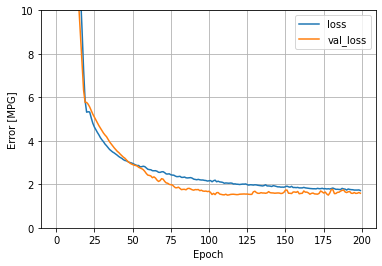

In [52]:
# Training
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.15,
    verbose=0, epochs=200)
plot_loss(history)

In [53]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

#III. Performance

In [54]:
# Performance
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T


,Mean absolute error [MPG]
weight_model,3.255366
linear_model,2.747938
dnn_weight_model,3.017860
dnn_model,2.151916


##1. Make predictions

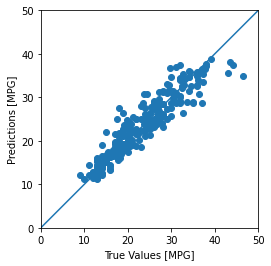

In [55]:
# Make Predictions
test_predictions = dnn_model.predict(test_features).flatten()
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

##2. Error distribution

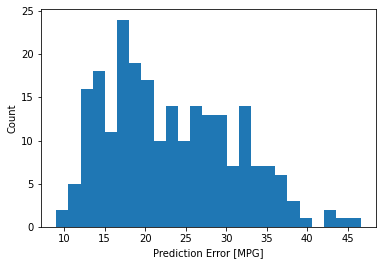

In [56]:
# Error distribution
error = rest_predictions = test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

##3. Saving the model

In [57]:
# Saving the model
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


##4. Rerunning the model

In [58]:
# Rerunning the model
reloaded = tf.keras.models.load_model('dnn_model')
test_results['reloaded'] = reloaded.evaluate(
	test_features, test_labels, verbose=0)
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
weight_model,3.255366
linear_model,2.747938
dnn_weight_model,3.017860
dnn_model,2.151916
reloaded,2.151916
